https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting/writeups/evgeniia-grigoreva-private-lb-8th-solution Market averages: Averages per date_id and time_id.
Rolling statistics: Rolling averages and standard deviations over the last 1000 time_ids for each symbol.
Besides that, I added time_id as a feature.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c hull-tactical-market-prediction
!unzip /content/hull-tactical-market-prediction.zip
!rm /content/hull-tactical-market-prediction.zip

Mounted at /content/drive
  0% 0.00/4.01M [00:00<?, ?B/s]
100% 4.01M/4.01M [00:00<00:00, 159MB/s]
Archive:  /content/hull-tactical-market-prediction.zip
  inflating: kaggle_evaluation/__init__.py  
  inflating: kaggle_evaluation/core/__init__.py  
  inflating: kaggle_evaluation/core/base_gateway.py  
  inflating: kaggle_evaluation/core/generated/__init__.py  
  inflating: kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py  
  inflating: kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py  
  inflating: kaggle_evaluation/core/kaggle_evaluation.proto  
  inflating: kaggle_evaluation/core/relay.py  
  inflating: kaggle_evaluation/core/templates.py  
  inflating: kaggle_evaluation/default_gateway.py  
  inflating: kaggle_evaluation/default_inference_server.py  
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%%capture
# !pip install autogluon.tabular[all]

## Import Packages

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest, f_regression

# from autogluon.tabular import TabularDataset, TabularPredictor

## Load Data

M* - Market Dynamics/Technical features.
E* - Macro Economic features.
I* - Interest Rate features.
P* - Price/Valuation features.
V* - Volatility features.
S* - Sentiment features.
MOM* - Momentum features.
D* - Dummy/Binary features.

In [ ]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
# sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
train.iloc[:,:3].head(14)

,D1,D2,D3
date_id,,,
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,0,0


In [ ]:
target = ['forward_returns', 'risk_free_rate',	'market_forward_excess_returns']
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()[:-4]
categorical_cols = test.select_dtypes([object]).columns.tolist()

In [ ]:
train.shape, test.shape

((8990, 97), (10, 98))

In [ ]:
train.iloc[:,:4].head(14)

,D1,D2,D3,D4
date_id,,,,
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
5,0,0,0,1
6,0,0,0,1
7,0,0,0,1
8,0,0,0,1


## EDA

### Missing Values Check

In [ ]:
# Initialize a list to store data
data = []

for column in train.columns:
    data_type = str(train[column].dtype)

    # Calculate missing percentages
    train_missing = np.round(100 - train[column].count() / train.shape[0] * 100, 1)

    if column not in target:
        test_missing = np.round(100 - test[column].count() / test.shape[0] * 100, 1)
        unique_values_count_test = test[column].nunique()

        # Compute unique values in train that are NOT in test
        unique_train_values = set(train[column].dropna().unique())
        unique_test_values = set(test[column].dropna().unique())
        unseen_in_test = len( unique_test_values - unique_train_values)
        unseen_percentage = np.round((unseen_in_test / len(unique_train_values)) * 100, 2) if len(unique_train_values) > 0 else 0
    else:
        test_missing = "NA"
        unique_values_count_test = "NA"
        unseen_percentage = "NA"

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = np.round(train[column].nunique() / train.shape[0], 4)
    unique_values_count = train[column].nunique()

    # Append row to list
    data.append([column, data_type, train_missing, test_missing,
                 discrete_ratio, unique_values_count, unique_values_count_test, unseen_percentage])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',
                                         'Discrete Ratio (Train)', 'Unique Values Count Train',
                                         'Unique Values Count Test', 'Unique % Unseen in Test'])

# Display the DataFrame
df_summary


,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
0,D1,int64,0.0,0.0,0.0002,2,1,0.0
1,D2,int64,0.0,0.0,0.0002,2,1,0.0
2,D3,int64,0.0,0.0,0.0002,2,2,0.0
3,D4,int64,0.0,0.0,0.0002,2,1,0.0
4,D5,int64,0.0,0.0,0.0002,2,2,0.0
...,...,...,...,...,...,...,...,...
92,V8,float64,11.2,0.0,0.2544,2287,10,0.0
93,V9,float64,50.5,0.0,0.4951,4451,10,0.0
94,forward_returns,float64,0.0,NA,0.9913,8912,NA,NA
95,risk_free_rate,float64,0.0,NA,0.2143,1927,NA,NA


In [ ]:
df_summary.sort_values('Train Missing %', ascending = False)

,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
26,E7,float64,77.5,0.0,0.2248,2021,10,0.0
82,V10,float64,67.3,0.0,0.3271,2941,10,0.0
74,S3,float64,63.8,0.0,0.3623,3257,10,0.0
38,M1,float64,61.7,0.0,0.3830,3443,10,0.0
42,M13,float64,61.6,0.0,0.3838,3450,10,0.0
...,...,...,...,...,...,...,...,...
5,D6,int64,0.0,0.0,0.0002,2,1,0.0
4,D5,int64,0.0,0.0,0.0002,2,2,0.0
94,forward_returns,float64,0.0,NA,0.9913,8912,NA,NA
95,risk_free_rate,float64,0.0,NA,0.2143,1927,NA,NA


### Plots

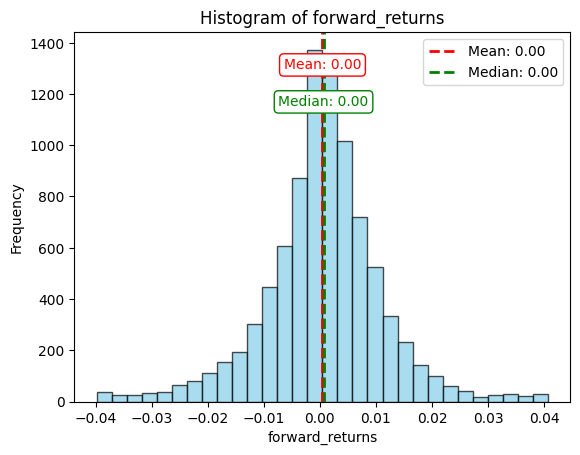

In [ ]:
target = 'forward_returns'

# Histogram for continuous target
plt.hist(train[target], bins=30, edgecolor='black', alpha=0.7, color='skyblue')

# Calculate mean and median
mean_value = np.mean(train[target])
median_value = np.median(train[target])

# Add vertical lines for mean and median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Add text annotations
plt.text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
plt.text(median_value, plt.ylim()[1] * 0.8, f'Median: {median_value:.2f}', color='green', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

# Labels and title
plt.xlabel(target)
plt.ylabel("Frequency")
plt.title(f"Histogram of {target}")
plt.legend()

In [ ]:
# Calculate the number of rows needed for the subplots
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each continuous column and plot the histograms
for i, col in enumerate(numeric_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins = round(range_val / bin_size)

    # Plot the histograms
    axs[i].hist(train[col], bins=num_bins, color='red', alpha=0.5, label='Train', edgecolor='black')
    axs[i].hist(test[col], bins=num_bins, color='grey', alpha=0.5, label='Test', edgecolor='black')

    # Titles and labels
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7e0b95d9fe20> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7e0b8480d9e0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
target = 'forward_returns'
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each numeric column and plot the scatter plot
for i, col in enumerate(numeric_cols):
    axs[i].scatter(train[col], train[target], alpha=0.5, color='blue', edgecolors='black')
    axs[i].set_title(f"{col} vs {target}")
    axs[i].set_xlabel(col)
    axs[i].set_ylabel(target)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
target = 'forward_returns'
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    ax1 = axs[i]

    # First y-axis for feature column
    ax1.plot(train.index, train[col], color='tab:blue', label=col)
    ax1.set_xlabel('Index')
    ax1.set_ylabel(col, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Second y-axis for target
    ax2 = ax1.twinx()
    ax2.plot(train.index, train[target], color='tab:red', alpha=0.6, label=target)
    ax2.set_ylabel(target, color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Title
    ax1.set_title(f"{col} and {target} over index")

    # Optional: align legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
corr = train[numeric_cols + [target]].corr()
plt.figure(figsize = (10, 8), dpi = 300)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True, annot_kws = {'size' : 7}, vmin = -1, vmax = 1)
plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
plt.show()

In [ ]:
corr[target].sort_values()

In [ ]:
train["day_of_week"] = train.index % 5
train['month_of_year'] = (train.index // 20) % 12

In [ ]:
plt.figure(figsize=(8, 5))
train.boxplot(column="market_forward_excess_returns", by="month_of_year")
plt.title("Market Forward Excess Returns by month_of_year")
plt.suptitle("")  # removes default Pandas subtitle
plt.xlabel("month_of_year")
plt.ylabel("Market Forward Excess Returns")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
train.boxplot(column="market_forward_excess_returns", by="day_of_week")
plt.title("Market Forward Excess Returns by Day of Week")
plt.suptitle("")  # removes default Pandas subtitle
plt.xlabel("Day of Week (0 = Monday)")
plt.ylabel("Market Forward Excess Returns")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## Scoring Function

In [3]:
import pandas.api.types
MIN_INVESTMENT = 0
MAX_INVESTMENT = 2

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """

    if not pandas.api.types.is_numeric_dtype(submission['prediction']):
        raise ParticipantVisibleError('Predictions must be numeric')

    solution = solution
    solution['position'] = submission['prediction']

    if solution['position'].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_INVESTMENT}')
    if solution['position'].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_INVESTMENT}')

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()

    trading_days_per_yr = 252
    if strategy_std == 0:
        raise ParticipantVisibleError('Division by zero, strategy std is zero')
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()

    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    if market_volatility == 0:
        raise ParticipantVisibleError('Division by zero, market std is zero')

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

## Linear Regression Models

1. alternate ret strategies - done, revisit nonlinear later
2. Feature engineering (lags, rolling stats, momentum, interaction terms, vol-adjusted features).
3. Feature selection
4. Walk-forward (time-series) CV + metric that penalizes excess volatility beyond 120% of market.
5. Smaller data window

In [ ]:
import os
from pathlib import Path
import datetime

from tqdm import tqdm
from dataclasses import dataclass, asdict

import polars as pl
import numpy as np
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
# Config
# ============ PATHS ============
DATA_PATH: Path = Path('/content/')

# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal
SIGNAL_MULTIPLIER: float = 400.0                # Multiplier of the OLS market forward excess returns predictions to signal

# ============ MODEL CONFIGS ============
CV: int = 10                                    # Number of cross validation folds in the model fitting
L1_RATIO: float = 0.5                           # ElasticNet mixing parameter
ALPHAS: np.ndarray = np.logspace(-4, 2, 100)    # Constant that multiplies the penalty terms
MAX_ITER: int = 1000000                         # The maximum number of iterations

In [ ]:
@dataclass
class DatasetOutput:
    X_train : pl.DataFrame
    X_test: pl.DataFrame
    y_train: pl.Series
    y_test: pl.Series
    scaler: StandardScaler

@dataclass
class ElasticNetParameters:
    l1_ratio : float
    cv: int
    alphas: np.ndarray
    max_iter: int

    def __post_init__(self):
        if self.l1_ratio < 0 or self.l1_ratio > 1:
            raise ValueError("Wrong initializing value for ElasticNet l1_ratio")

@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL

In [ ]:
# Set Parameters
ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

enet_params = ElasticNetParameters(
    l1_ratio = L1_RATIO,
    cv = CV,
    alphas = ALPHAS,
    max_iter = MAX_ITER
)

In [ ]:
# Helper Functions
def load_trainset() -> pl.DataFrame:
    """
    Loads and preprocesses the training dataset.

    Returns:
        pl.DataFrame: The preprocessed training DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "train.csv")
        .rename({'market_forward_excess_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        ).with_columns(
        (pl.col("date_id") % 5).alias("day_of_week")
    ).with_columns(((pl.col("date_id") // 20) % 12).alias("month")).head(-10)
    )

def load_testset() -> pl.DataFrame:
    """
    Loads and preprocesses the testing dataset.

    Returns:
        pl.DataFrame: The preprocessed testing DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "test.csv")
        .rename({'lagged_forward_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        ).with_columns(
        (pl.col("date_id") % 5).alias("day_of_week")
    )
    )

def create_example_dataset(df: pl.DataFrame) -> pl.DataFrame:
    """
    Creates new features and cleans a DataFrame.

    Args:
        df (pl.DataFrame): The input Polars DataFrame.

    Returns:
        pl.DataFrame: The DataFrame with new features, selected columns, and no null values.
    """
    vars_to_keep = [
        "S2", "E2", "E3", "P9", "S1", "S5", "I2", "P8",
        "P10", "P12", "P13", "U1", "U2"
    ]

    return (
        df.with_columns(
            (pl.col("I2") - pl.col("I1")).alias("U1"),
            (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3)).alias("U2")
        )
        .select(["date_id", "target"] + vars_to_keep)
        .with_columns([
            pl.col(col).fill_null(pl.col(col).ewm_mean(com=0.5))
            for col in vars_to_keep
        ])
        .drop_nulls()
    )

def join_train_test_dataframes(train: pl.DataFrame, test: pl.DataFrame) -> pl.DataFrame:
    """
    Joins two dataframes by common columns and concatenates them vertically.

    Args:
        train (pl.DataFrame): The training DataFrame.
        test (pl.DataFrame): The testing DataFrame.

    Returns:
        pl.DataFrame: A single DataFrame with vertically stacked data from common columns.
    """
    common_columns: list[str] = [col for col in train.columns if col in test.columns]

    return pl.concat([train.select(common_columns), test.select(common_columns)], how="vertical")

def split_dataset(train: pl.DataFrame, test: pl.DataFrame, features: list[str]) -> DatasetOutput:
    """
    Splits the data into features (X) and target (y), and scales the features.

    Args:
        train (pl.DataFrame): The processed training DataFrame.
        test (pl.DataFrame): The processed testing DataFrame.
        features (list[str]): List of features to used in model.

    Returns:
        DatasetOutput: A dataclass containing the scaled feature sets, target series, and the fitted scaler.
    """
    X_train = train.drop(['date_id','target'])
    y_train = train.get_column('target')
    X_test = test.drop(['date_id','target'])
    y_test = test.get_column('target')

    scaler = StandardScaler() #MinMaxScaler() #StandardScaler()

    X_train_scaled_np = scaler.fit_transform(X_train)
    X_train = pl.from_numpy(X_train_scaled_np, schema=features)

    X_test_scaled_np = scaler.transform(X_test)
    X_test = pl.from_numpy(X_test_scaled_np, schema=features)


    return DatasetOutput(
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test,
        scaler = scaler
    )

In [ ]:
def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters
) -> np.ndarray:
    """
    Converts raw model predictions (expected returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.
        params (RetToSignalParameters): Parameters for scaling and clipping the signal.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """
    return np.clip(
        ret_arr * params.signal_multiplier + 1, params.min_signal, params.max_signal
    )

def zscore_ret_to_signal(ret_arr, lookback=100, clip_range=(0, 2)):
    mean = np.mean(ret_arr[-lookback:])
    std = np.std(ret_arr[-lookback:])
    zscores = (ret_arr - mean) / (std + 1e-8)
    return np.clip(1 + zscores * 0.2, *clip_range)

def quantile_signal(ret_arr, n_quantiles=5, clip_range=(0, 2)):
    ranks = pd.qcut(ret_arr, n_quantiles, labels=False, duplicates='drop')
    return np.clip(1 + (ranks - n_quantiles//2) / (n_quantiles//2), *clip_range)

def vol_adjusted_signal(ret_arr, vol_arr, target_vol=0.02, clip_range=(0, 2)):
    adj_signal = 1 + (ret_arr / (vol_arr + 1e-8)) * target_vol
    return np.clip(adj_signal, *clip_range)

def nonlinear_signal(ret_arr, scale=5.0, clip_range=(0, 2)):
    signal = 1 + np.tanh(scale * ret_arr)
    return np.clip(signal, *clip_range)

def threshold_signal(ret_arr, pos_thresh=0.01, neg_thresh=-0.01):
    signal = np.where(ret_arr > pos_thresh, 2, np.where(ret_arr < neg_thresh, 0, 1))
    return signal

In [ ]:
train = load_trainset()
test = load_testset()

market_cols = ['M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
macro_cols = ['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9']
rate_cols = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9']
price_cols = ['P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
vol_cols = ['V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
sent_cols = ['S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
# mom_cols = [c for c in df.columns if c.startswith("MOM")]
dummy_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']

df = join_train_test_dataframes(train, test)

In [ ]:
# Feat engineer
def std_horizontal(cols: list[str]) -> pl.Expr:
    mean = pl.mean_horizontal(cols)
    return ((sum((pl.col(c) - mean) ** 2 for c in cols) / len(cols)).sqrt())

df = df.with_columns([
    # Mean and standard deviation across M features
    pl.mean_horizontal(market_cols).alias("M_mean"),
    std_horizontal(market_cols).alias("M_std"),
    # Normalized versions (z-scores)
    *[
        ((pl.col(c) - pl.mean_horizontal(market_cols)) / std_horizontal(market_cols)).alias(f"{c}_z")
        for c in market_cols
    ],
])

# Momentum
df = df.with_columns([
    pl.mean_horizontal(macro_cols).alias("E_composite"),
    (pl.max_horizontal(macro_cols) - pl.min_horizontal(macro_cols)).alias("E_range"),
])

for c in macro_cols:
    df = df.with_columns(
        (pl.col(c) - pl.col(c).shift(5)).alias(f"{c}_5d_change")
    )

# Interest Rates
df = df.with_columns([
    pl.mean_horizontal(rate_cols).alias("I_avg_yield"),
    (pl.col("I1") - pl.col("I9")).alias("I_yield_spread"),  # short vs long
    (pl.col("I1") - pl.col("I1").shift(5)).alias("I_short_rate_change_5d"),
])

# Price Valuation
df = df.with_columns([
    pl.mean_horizontal(price_cols).alias("P_mean"),
    (pl.max_horizontal(price_cols) / (pl.min_horizontal(price_cols) + 1e-9)).alias("P_ratio_range"),
])

for c in price_cols:
    df = df.with_columns([
        (pl.col(c) - pl.col(c).shift(10)).alias(f"{c}_10d_momentum"),
    ])

# Add vol (Lose a lot of rows)
df = df.with_columns([
    pl.mean_horizontal(vol_cols).alias("V_mean"),
    std_horizontal(vol_cols).alias("V_std"),
    *[
        (pl.col(col).abs() + 1e-6).log1p().fill_nan(0).alias(f"{col}_log_vol")
        for col in vol_cols
    ],
])

# Add Sent
df = df.with_columns([
    pl.mean_horizontal(sent_cols).alias("S_mean"),
    pl.max_horizontal(sent_cols).alias("S_max"),
    (pl.col("S1") - pl.col("S1").shift(3)).alias("S1_3d_delta"),
])

# Dummy
df = df.with_columns([
    pl.sum_horizontal(dummy_cols).alias("D_sum_active"),
])
df = df.with_columns([
    # (pl.col("M_mean") + pl.col("MOM_mean") - pl.col("V_mean")).alias("risk_adjusted_momentum"),
    (pl.col("S_mean") * pl.col("E_composite")).alias("macro_sentiment_signal"),
])

df.shape, df.drop_nulls().shape

((8990, 177), (2016, 177))

In [ ]:
# df.select([
#     pl.col(c).is_null().sum().alias(c)
#     for c in df.columns
# ])

In [ ]:
df = df.with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
]).drop_nulls()

# df = df.with_columns([
#     pl.col(c).fill_null(0).alias(c)
#     for c in df.columns
# ]).drop_nulls()
# df = create_example_dataset(df=df)





# Train test split
train = df.filter(pl.col('date_id').is_in(train.get_column('date_id')))
test = df.filter(pl.col('date_id').is_in(test.get_column('date_id')))

FEATURES = [col for col in test.columns if col not in ['date_id', 'target']]
# feats = ['E16',
#  'E17',
#  'E18',
#  'E2',
#  'I5',
#  'I8',
#  'M11',
#  'M14',
#  'P11',
#  'P2',
#  'P6',
#  'P8',
#  'V13',
#  'V7',
#  'V9']

dataset = split_dataset(train=train, test=test, features=FEATURES)

X_train = dataset.X_train
X_test = dataset.X_test
y_train = dataset.y_train
y_test = dataset.y_test
scaler = dataset.scaler

df.shape

(2021, 97)

In [ ]:
model = LinearRegression()
# model = ElasticNetCV(**asdict(enet_params)) #
model.fit(X_train, y_train)

LinearRegression()

Base lin reg
Train RMSE: 0.0111
Test RMSE:  0.0053
Train R²:   0.0057
Test R²:    -0.0491

all feats lin reg: Train RMSE: 0.0103
Test RMSE:  0.0050
Train R²:   0.0921
Test R²:    0.0648

all feats er: Train RMSE: 0.0107
Test RMSE:  0.0053
Train R²:   0.0183
Test R²:    -0.0298

train rfe: Train RMSE: 0.0105
Test RMSE:  0.0056
Train R²:   0.0529
Test R²:    -0.1610

train er rfe: Train RMSE: 0.0104
Test RMSE:  0.0053
Train R²:   0.0430
Test R²:    -0.0492

*RFE not good

train LR all feats + date feats Train RMSE: 0.0103
Test RMSE:  0.0062
Train R²:   0.0923
Test R²:    -0.4169

same fillna 0 Train RMSE: 0.0104
Test RMSE:  0.0054
Train R²:   0.0249
Test R²:    -0.0874

added m: Train RMSE: 0.0103
Test RMSE:  0.0059
Train R²:   0.1046
Test R²:    -0.2768

added e: Train RMSE: 0.0103
Test RMSE:  0.0059
Train R²:   0.1046
Test R²:    -0.2830

all feat eng: Train RMSE: 0.0094
Test RMSE:  0.0068
Train R²:   0.1913
Test R²:    -0.6936

In [ ]:
# # model = LinearRegression()
# model = ElasticNetCV(**asdict(enet_params))
# selector = RFE(model, n_features_to_select=15)
# X_train_selected = selector.fit_transform(X_train, y_train)
# X_test_selected = selector.transform(X_test)

In [ ]:
# selected_features = selector.get_feature_names_out()
# selected_features = selected_features.tolist()
# X_train_sel = pl.DataFrame(selector.transform(X_train.to_numpy()), schema=selected_features)
# X_test_sel = pl.DataFrame(selector.transform(X_test.to_numpy()), schema=selected_features)

# # Fit model using selected features
# model.fit(X_train_selected, y_train)


Train RMSE: 0.0103
Test RMSE:  0.0062
Train R²:   0.0923
Test R²:    -0.4169


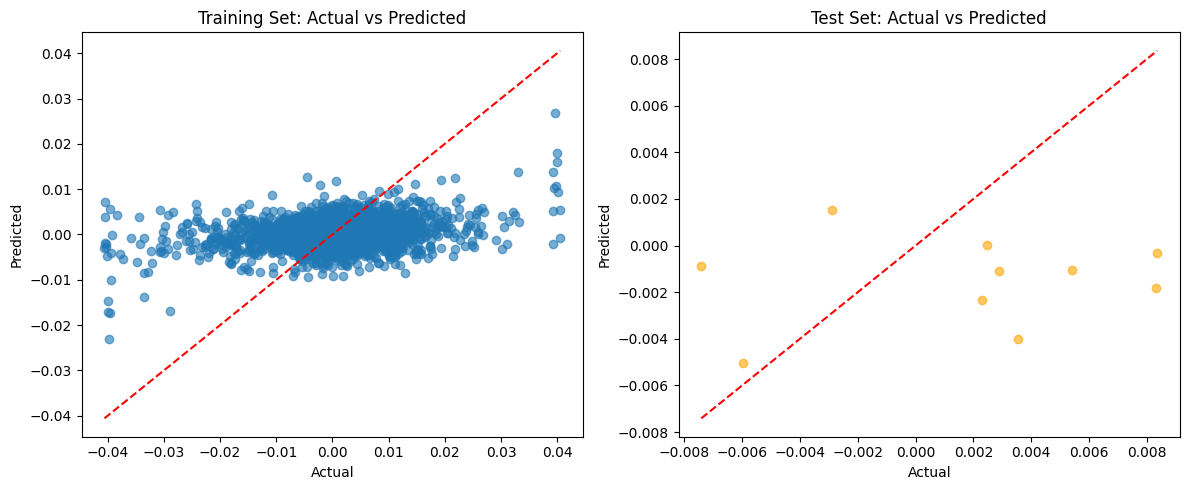

In [ ]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(f"Train R²:   {train_r2:.4f}")
print(f"Test R²:    {test_r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 5))

# Training performance
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')

# Test performance
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='orange')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.tight_layout()
plt.show()

        feature  coefficient  abs_coef
20           E2     0.018848  0.018848
58          P11    -0.016573  0.016573
61           P2     0.011727  0.011727
82          V10    -0.011133  0.011133
86           V2    -0.010671  0.010671
162  V2_log_vol     0.010444  0.010444
17          E17    -0.010063  0.010063
38           M1     0.008579  0.008579
168  V8_log_vol     0.008038  0.008038
40          M11    -0.007413  0.007413


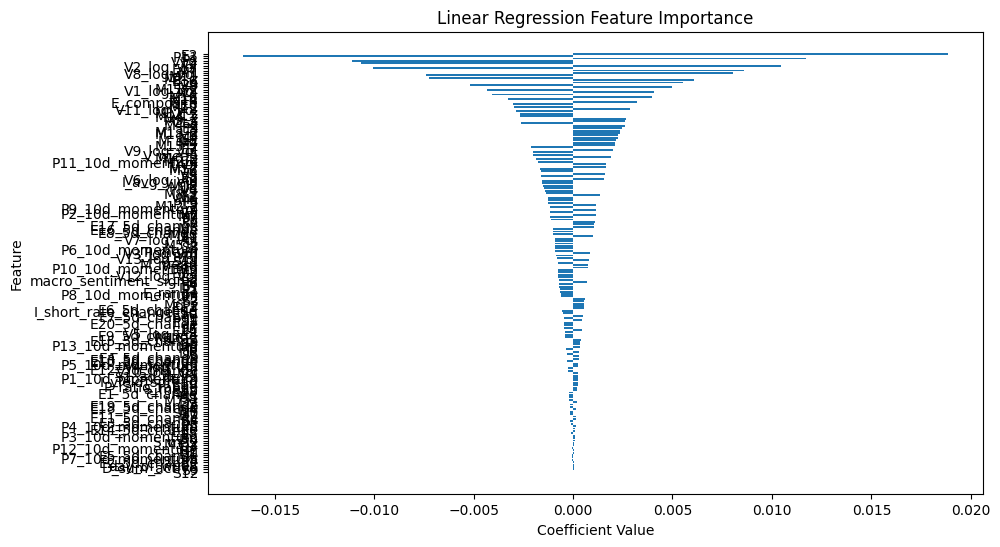

In [ ]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_
})

# Sort by absolute magnitude of coefficients
importance["abs_coef"] = importance["coefficient"].abs()
importance = importance.sort_values("abs_coef", ascending=False)

# Display top features
print(importance.head(10))

# Optional: Plot
plt.figure(figsize=(10, 6))
plt.barh(importance["feature"], importance["coefficient"])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Linear Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
solution = load_trainset().with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
]).drop_nulls().to_pandas()

solution['prediction'] = convert_ret_to_signal(y_train_pred, ret_signal_params)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

2.2165875132731583

In [ ]:
# def predict(test: pl.DataFrame) -> float:
#     test = test.rename({'lagged_forward_returns':'target'})
#     df: pl.DataFrame = create_example_dataset(test)
#     X_test: pl.DataFrame = df.select(FEATURES)
#     X_test_scaled_np: np.ndarray = scaler.transform(X_test)
#     X_test: pl.DataFrame = pl.from_numpy(X_test_scaled_np, schema=FEATURES)
#     raw_pred: float = model.predict(X_test)[0]
#     return convert_ret_to_signal(raw_pred, ret_signal_params)

# inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

# if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
#     inference_server.serve()
# else:
#     inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))

## Histogram Gradient Boosting Models
1. alternate ret strategies - done, revisit nonlinear later
2. Feature engineering (lags, rolling stats, momentum, interaction terms, vol-adjusted features).
2a. Add Cyclic Date with sin and cos
3. Feature selection
4. Walk-forward (time-series) CV + metric that penalizes excess volatility beyond 120% of market.
5. Smaller data window
6. Optimize for R2 more priority, create CV metric

In [4]:
import os
from pathlib import Path
import datetime

from tqdm import tqdm
from dataclasses import dataclass, asdict

import polars as pl
import numpy as np
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor

# Config
# ============ PATHS ============
DATA_PATH: Path = Path('/content/')

# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal
SIGNAL_MULTIPLIER: float = 400.0                # Multiplier of the OLS market forward excess returns predictions to signal

# ============ MODEL CONFIGS ============
CV: int = 10                                    # Number of cross validation folds in the model fitting
L1_RATIO: float = 0.5                           # ElasticNet mixing parameter
ALPHAS: np.ndarray = np.logspace(-4, 2, 100)    # Constant that multiplies the penalty terms
MAX_ITER: int = 1000000                         # The maximum number of iterations


@dataclass
class DatasetOutput:
    X_train : pl.DataFrame
    X_test: pl.DataFrame
    y_train: pl.Series
    y_test: pl.Series
    scaler: StandardScaler

@dataclass
class ElasticNetParameters:
    l1_ratio : float
    cv: int
    alphas: np.ndarray
    max_iter: int

    def __post_init__(self):
        if self.l1_ratio < 0 or self.l1_ratio > 1:
            raise ValueError("Wrong initializing value for ElasticNet l1_ratio")

@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL


# Set Parameters
ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

enet_params = ElasticNetParameters(
    l1_ratio = L1_RATIO,
    cv = CV,
    alphas = ALPHAS,
    max_iter = MAX_ITER
)

In [5]:
# Helper Functions
def load_trainset() -> pl.DataFrame:
    """
    Loads and preprocesses the training dataset.

    Returns:
        pl.DataFrame: The preprocessed training DataFrame.
    """

    return (
    pl.read_csv(DATA_PATH / "train.csv")
    .rename({"market_forward_excess_returns": "target"})
    .with_columns(
        pl.exclude("date_id").cast(pl.Float64, strict=False)
    )
    .with_columns(
        (pl.col("date_id") % 5).alias("day_of_week"),
        ((pl.col("date_id") // 20) % 12).alias("month")
    )
    .with_columns([
        # Cyclic encoding for day_of_week (period = 5)
        (pl.col("day_of_week") * (2 * np.pi / 5)).sin().alias("day_of_week_sin"),
        (pl.col("day_of_week") * (2 * np.pi / 5)).cos().alias("day_of_week_cos"),

        # Cyclic encoding for month (period = 12)
        (pl.col("month") * (2 * np.pi / 12)).sin().alias("month_sin"),
        (pl.col("month") * (2 * np.pi / 12)).cos().alias("month_cos"),
    ])
    .head(-10)
)

def load_testset() -> pl.DataFrame:
    """
    Loads and preprocesses the testing dataset.

    Returns:
        pl.DataFrame: The preprocessed testing DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "test.csv")
        .rename({'lagged_forward_returns':'target'})
        .with_columns(
        pl.exclude("date_id").cast(pl.Float64, strict=False)
    )
    .with_columns(
        (pl.col("date_id") % 5).alias("day_of_week"),
        ((pl.col("date_id") // 20) % 12).alias("month")
    )
    .with_columns([
        # Cyclic encoding for day_of_week (period = 5)
        (pl.col("day_of_week") * (2 * np.pi / 5)).sin().alias("day_of_week_sin"),
        (pl.col("day_of_week") * (2 * np.pi / 5)).cos().alias("day_of_week_cos"),

        # Cyclic encoding for month (period = 12)
        (pl.col("month") * (2 * np.pi / 12)).sin().alias("month_sin"),
        (pl.col("month") * (2 * np.pi / 12)).cos().alias("month_cos"),
    ])
    )

def create_example_dataset(df: pl.DataFrame) -> pl.DataFrame:
    """
    Creates new features and cleans a DataFrame.

    Args:
        df (pl.DataFrame): The input Polars DataFrame.

    Returns:
        pl.DataFrame: The DataFrame with new features, selected columns, and no null values.
    """
    vars_to_keep = [
        "S2", "E2", "E3", "P9", "S1", "S5", "I2", "P8",
        "P10", "P12", "P13", "U1", "U2"
    ]

    return (
        df.with_columns(
            (pl.col("I2") - pl.col("I1")).alias("U1"),
            (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3)).alias("U2")
        )
        .select(["date_id", "target"] + vars_to_keep)
        .with_columns([
            pl.col(col).fill_null(pl.col(col).ewm_mean(com=0.5))
            for col in vars_to_keep
        ])
        .drop_nulls()
    )

def join_train_test_dataframes(train: pl.DataFrame, test: pl.DataFrame) -> pl.DataFrame:
    """
    Joins two dataframes by common columns and concatenates them vertically.

    Args:
        train (pl.DataFrame): The training DataFrame.
        test (pl.DataFrame): The testing DataFrame.

    Returns:
        pl.DataFrame: A single DataFrame with vertically stacked data from common columns.
    """
    common_columns: list[str] = [col for col in train.columns if col in test.columns]

    return pl.concat([train.select(common_columns), test.select(common_columns)], how="vertical")

def split_dataset(train: pl.DataFrame, test: pl.DataFrame, features: list[str]) -> DatasetOutput:
    """
    Splits the data into features (X) and target (y), and scales the features.

    Args:
        train (pl.DataFrame): The processed training DataFrame.
        test (pl.DataFrame): The processed testing DataFrame.
        features (list[str]): List of features to used in model.

    Returns:
        DatasetOutput: A dataclass containing the scaled feature sets, target series, and the fitted scaler.
    """
    X_train = train.drop(['date_id','target'])
    y_train = train.get_column('target')
    X_test = test.drop(['date_id','target'])
    y_test = test.get_column('target')

    scaler = StandardScaler() #MinMaxScaler() #StandardScaler()

    X_train_scaled_np = scaler.fit_transform(X_train)
    X_train = pl.from_numpy(X_train_scaled_np, schema=features)

    X_test_scaled_np = scaler.transform(X_test)
    X_test = pl.from_numpy(X_test_scaled_np, schema=features)


    return DatasetOutput(
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test,
        scaler = scaler
    )

In [6]:
def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters
) -> np.ndarray:
    """
    Converts raw model predictions (expected returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.
        params (RetToSignalParameters): Parameters for scaling and clipping the signal.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """
    return np.clip(
        ret_arr * params.signal_multiplier + 1, params.min_signal, params.max_signal
    )

def zscore_ret_to_signal(ret_arr, lookback=100, clip_range=(0, 2)):
    mean = np.mean(ret_arr[-lookback:])
    std = np.std(ret_arr[-lookback:])
    zscores = (ret_arr - mean) / (std + 1e-8)
    return np.clip(1 + zscores * 0.2, *clip_range)

def quantile_signal(ret_arr, n_quantiles=5, clip_range=(0, 2)):
    ranks = pd.qcut(ret_arr, n_quantiles, labels=False, duplicates='drop')
    return np.clip(1 + (ranks - n_quantiles//2) / (n_quantiles//2), *clip_range)

def vol_adjusted_signal(ret_arr, vol_arr, target_vol=0.02, clip_range=(0, 2)):
    adj_signal = 1 + (ret_arr / (vol_arr + 1e-8)) * target_vol
    return np.clip(adj_signal, *clip_range)

def nonlinear_signal(ret_arr, scale=5.0, clip_range=(0, 2)):
    signal = 1 + np.tanh(scale * ret_arr)
    return np.clip(signal, *clip_range)

def threshold_signal(ret_arr, pos_thresh=0.01, neg_thresh=-0.01):
    signal = np.where(ret_arr > pos_thresh, 2, np.where(ret_arr < neg_thresh, 0, 1))
    return signal

In [59]:
train = load_trainset()
test = load_testset()

market_cols = ['M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
macro_cols = ['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9']
rate_cols = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9']
price_cols = ['P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
vol_cols = ['V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
sent_cols = ['S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
# mom_cols = [c for c in df.columns if c.startswith("MOM")]
dummy_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']

df = join_train_test_dataframes(train, test)
df = df.unique(subset=["date_id"], keep="first")

In [60]:
# Feat engineer
def std_horizontal(cols: list[str]) -> pl.Expr:
    mean = pl.mean_horizontal(cols)
    return ((sum((pl.col(c) - mean) ** 2 for c in cols) / len(cols)).sqrt())

def feat_eng(df):
  df = df.with_columns([
      # Mean and standard deviation across M features
      pl.mean_horizontal(market_cols).alias("M_mean"),
      std_horizontal(market_cols).alias("M_std"),
      # Normalized versions (z-scores)
      *[
          ((pl.col(c) - pl.mean_horizontal(market_cols)) / std_horizontal(market_cols)).alias(f"{c}_z")
          for c in market_cols
      ],
  ])

  # Momentum
  df = df.with_columns([
      pl.mean_horizontal(macro_cols).alias("E_composite"),
      (pl.max_horizontal(macro_cols) - pl.min_horizontal(macro_cols)).alias("E_range"),
  ])

  # # for c in macro_cols:
  # #     df = df.with_columns(
  # #         (pl.col(c) - pl.col(c).shift(5)).alias(f"{c}_5d_change")
  # #     )

  # Interest Rates
  df = df.with_columns([
      pl.mean_horizontal(rate_cols).alias("I_avg_yield"),
      (pl.col("I1") - pl.col("I9")).alias("I_yield_spread"),  # short vs long
      # (pl.col("I1") - pl.col("I1").shift(5)).alias("I_short_rate_change_5d"),
  ])

  # Price Valuation
  df = df.with_columns([
      pl.mean_horizontal(price_cols).alias("P_mean"),
      (pl.max_horizontal(price_cols) / (pl.min_horizontal(price_cols) + 1e-9)).alias("P_ratio_range"),
  ])

  # # for c in price_cols:
  # #     df = df.with_columns([
  # #         (pl.col(c) - pl.col(c).shift(10)).alias(f"{c}_10d_momentum"),
  # #     ])

  # Add vol (Lose a lot of rows)
  df = df.with_columns([
      pl.mean_horizontal(vol_cols).alias("V_mean"),
      std_horizontal(vol_cols).alias("V_std"),
      *[
          (pl.col(col).abs() + 1e-6).log1p().fill_nan(0).alias(f"{col}_log_vol")
          for col in vol_cols
      ],
  ])

  # # Add Sent
  df = df.with_columns([
      pl.mean_horizontal(sent_cols).alias("S_mean"),
      pl.max_horizontal(sent_cols).alias("S_max"),
      # (pl.col("S1") - pl.col("S1").shift(3)).alias("S1_3d_delta"),
  ])

  # # Dummy
  df = df.with_columns([
      pl.sum_horizontal(dummy_cols).alias("D_sum_active"),
  ])
  df = df.with_columns([
      # (pl.col("M_mean") + pl.col("MOM_mean") - pl.col("V_mean")).alias("risk_adjusted_momentum"),
      (pl.col("S_mean") * pl.col("E_composite")).alias("macro_sentiment_signal"),
  ])

  return df

df = feat_eng(df)
df.shape, df.drop_nulls().shape

((9011, 147), (2042, 147))

In [61]:
df = df.with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
]).drop_nulls()

# df = df.with_columns([
#     pl.col(c).fill_null(0).alias(c)
#     for c in df.columns
# ]).drop_nulls()
# df = create_example_dataset(df=df)


# Train test split
train = df.filter(pl.col('date_id').is_in(train.get_column('date_id')))
test = df.filter(pl.col('date_id').is_in(test.get_column('date_id')))

FEATURES = [col for col in test.columns if col not in ['date_id', 'target']]
feats = ['E10', 'E19', 'E2', 'E3', 'E7', 'E9', 'I2', 'I3', 'I4', 'I7', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M2', 'M3', 'M4', 'M8', 'M9', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S8', 'S9', 'V13', 'V5', 'V7', 'V9', 'M1_z', 'M10_z', 'M11_z', 'M12_z', 'M13_z', 'M14_z', 'M16_z', 'M17_z', 'M2_z', 'M3_z', 'M4_z', 'M8_z', 'M9_z', 'E_range', 'I_avg_yield', 'P_mean', 'P_ratio_range', 'V_mean', 'V_std', 'V13_log_vol', 'V5_log_vol', 'V7_log_vol', 'V9_log_vol', 'S_mean', 'S_max', 'macro_sentiment_signal']
# feats = ['E16',
#  'E17',
#  'E18',
#  'E2',
#  'I5',
#  'I8',
#  'M11',
#  'M14',
#  'P11',
#  'P2',
#  'P6',
#  'P8',
#  'V13',
#  'V7',
#  'V9']

dataset = split_dataset(train=train, test=test, features=FEATURES)

X_train = dataset.X_train[feats]
X_test = dataset.X_test[feats]
y_train = dataset.y_train
y_test = dataset.y_test
scaler = dataset.scaler

df.shape

/tmp/ipython-input-520262648.py:14: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  train = df.filter(pl.col('date_id').is_in(train.get_column('date_id')))
/tmp/ipython-input-520262648.py:15: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  test = df.filter(pl.col('date_id').is_in(test.get_column('date_id')))


(2042, 147)

In [62]:
# model = HistGradientBoostingRegressor()
model = HistGradientBoostingRegressor(
    # **{'loss': 'squared_error', 'learning_rate': 0.1448510689927439,
    #  'random_state': 30,
    #  'max_iter': 1138, 'max_leaf_nodes': 232, 'max_depth': 9, 'min_samples_leaf': 24,
    #  'l2_regularization': 0.009104904640684683, 'max_bins': 236}
    **{'loss': 'squared_error', 'learning_rate': 0.00737795745506236, 'max_iter': 601, 'max_leaf_nodes': 114,
     'random_state': 30,
     'max_depth': 4, 'min_samples_leaf': 10, 'l2_regularization': 1.7931711881472216e-05, 'max_bins': 32}
  #   **{'learning_rate': 0.21924616257442375,
  #      'random_state': 30,
  # 'max_iter': 921,
  #      'max_depth': 10,
  #      'max_leaf_nodes': 148,
  #      'min_samples_leaf': 31, 'l2_regularization': 2.4395926060234704e-05, 'max_features': 0.7030888031262532, 'max_bins': 232}
#     **{'learning_rate': 0.0010315847908288045,
#  'max_iter': 224,
#  'max_depth': 11,
#  'max_leaf_nodes': 188,
#  'min_samples_leaf': 65,
#  'l2_regularization': 0.00017344187014586235,
#  'max_features': 0.8212307821347176,
#  'max_bins': 21, 'random_state': 30}
    )



model.fit(X_train, y_train)

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# model = HistGradientBoostingRegressor(random_state=30)

# # Define hyperparameter grid
# param_grid = {
#     "learning_rate": [0.01, 0.05, 0.1],
#     "max_iter": [100, 300, 500],
#     "max_depth": [3, 5, 7],
#     "min_samples_leaf": [10, 20, 30],
#     "l2_regularization": [0.0, 0.1, 1.0],
# }

# # Time series CV (no shuffling)
# tscv = TimeSeriesSplit(n_splits=5)

# # Grid search with time series CV
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=tscv,
#     scoring= 'r2', #"neg_mean_squared_error",
#     n_jobs=-1,
#     verbose=1
# )

# grid_search.fit(X_train, y_train)

# # Best parameters and model
# print("Best Parameters:", grid_search.best_params_)
# best_model = grid_search.best_estimator_

# # Evaluate on the last validation fold
# y_pred = best_model.predict(X_train)
# rmse = mean_squared_error(y_train, y_pred)
# print(f"Training RMSE: {rmse:.4f}")

HistGradientBoostingRegressor(l2_regularization=1.7931711881472216e-05,
                              learning_rate=0.00737795745506236, max_bins=32,
                              max_depth=4, max_iter=601, max_leaf_nodes=114,
                              min_samples_leaf=10, random_state=30)

In [ ]:
# # Feature Selection (Was good)
# selector = SelectFromModel(
#     RandomForestRegressor(n_estimators=200, random_state=30),
#     threshold="median"  # keep top 50% of features
# )

# model = HistGradientBoostingRegressor(
#     loss='squared_error', learning_rate=0.1448510689927439,
#     random_state=30, max_iter=1138, max_leaf_nodes=232, max_depth=9,
#     min_samples_leaf=24, l2_regularization=0.009104904640684683, max_bins=236
# )


# pipe = Pipeline([
#     ("feature_selection", selector),
#     ("regressor", model)
# ])

# pipe.fit(X_train, y_train)

In [ ]:
# selector = pipe.named_steps["feature_selection"]
# mask = selector.get_support()  # Boolean mask of selected features
# feature_names = X_train.columns
# selected_features = [name for name, keep in zip(feature_names, mask) if keep]
# print(selected_features)

['E10', 'E19', 'E2', 'E3', 'E7', 'E9', 'I2', 'I3', 'I4', 'I7', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M2', 'M3', 'M4', 'M8', 'M9', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S8', 'S9', 'V13', 'V5', 'V7', 'V9', 'M1_z', 'M10_z', 'M11_z', 'M12_z', 'M13_z', 'M14_z', 'M16_z', 'M17_z', 'M2_z', 'M3_z', 'M4_z', 'M8_z', 'M9_z', 'E_range', 'I_avg_yield', 'P_mean', 'P_ratio_range', 'V_mean', 'V_std', 'V13_log_vol', 'V5_log_vol', 'V7_log_vol', 'V9_log_vol', 'S_mean', 'S_max', 'macro_sentiment_signal']


In [ ]:
# grid_search.cv_results_

Baseline Train RMSE: 0.0034
Test RMSE:  0.0064
Train R²:   0.9000
Test R²:    -0.5177

all feats Train RMSE: 0.0030
Test RMSE:  0.0065
Train R²:   0.9218
Test R²:    -0.5437

Train RMSE: 0.0083
Test RMSE:  0.0049
Train R²:   0.4126
Test R²:    0.0912


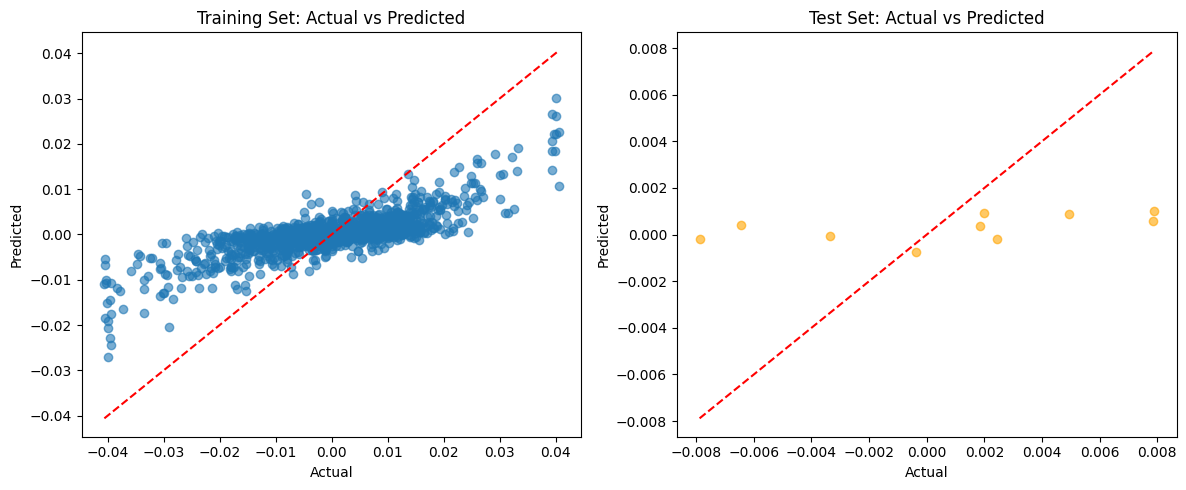

In [63]:
# Predictions
y_train_pred = model.predict(X_train)#model.predict(X_train)# pipe.predict(X_train)#
y_test_pred = model.predict(X_test)# #pipe.predict(X_test)#model.predict(X_test)

# Evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(f"Train R²:   {train_r2:.4f}")
print(f"Test R²:    {test_r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 5))

# Training performance
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')

# Test performance
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='orange')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.tight_layout()
plt.show()

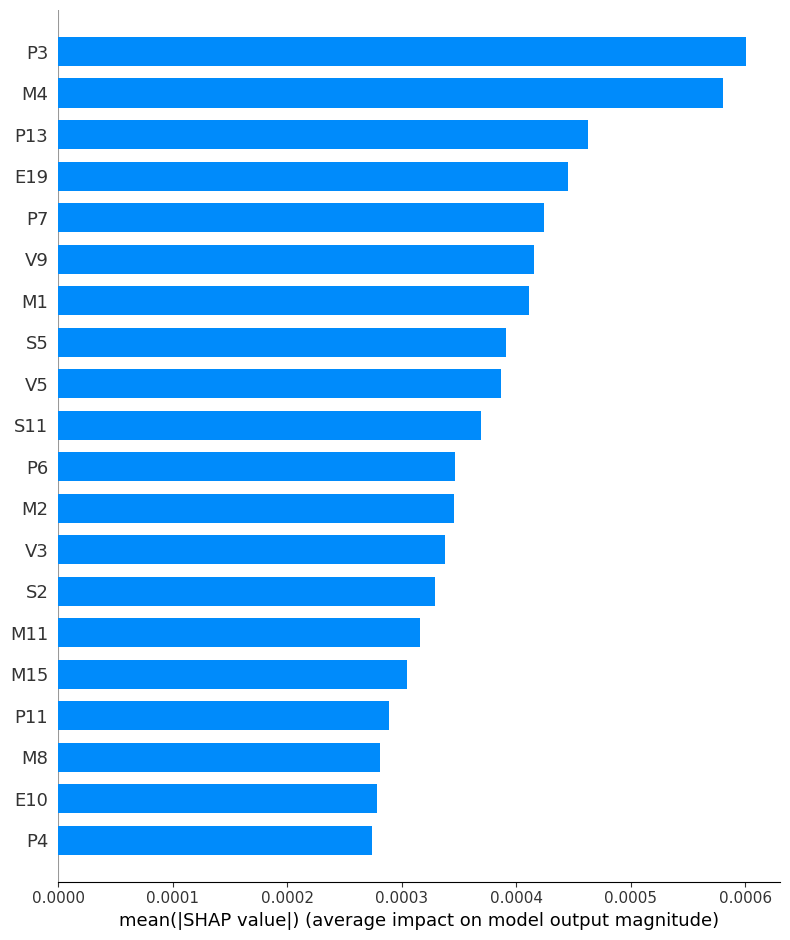

In [ ]:
import shap

# Create explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_train.to_pandas())

# Plot summary
shap.summary_plot(shap_values, X_train.to_pandas(), plot_type="bar")


All feats: 9.419272339746476 <br>
Baseline: 9.35143680081713 <br>
TSCV: 2.2582225113042416 <br>
hyperparam tune r2: 1.877413472278813 <br>
hyperparam tune rmse: 9.919875445392723 <br>
comp:  9.920277079486265 <br>
select_from_rf: 9.920286456857399 <br>


In [64]:
solution = feat_eng(load_trainset()).with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
]).drop_nulls().to_pandas()


solution['prediction'] = convert_ret_to_signal(y_train_pred, ret_signal_params)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

0.16781785001727625

In [26]:
score(solution, solution[['prediction']], row_id_column_name = 'date_id')

KeyError: "None of [Index(['prediction'], dtype='object')] are in the [columns]"

#### Optuna

In [9]:
%%capture
!pip install optuna

In [19]:
import optuna
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, r2_score
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer


# # Define your CV strategy
# tscv = TimeSeriesSplit(n_splits=5)

# def objective(trial):
#     # Suggest hyperparameters
#     params = {
#         # "loss": "squared_error",
#         # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
#         # "max_iter": trial.suggest_int("max_iter", 200, 1200),
#         # "max_depth": trial.suggest_int("max_depth", 3, 12),
#         # "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 15, 255),
#         # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 100),
#         # "l2_regularization": trial.suggest_float("l2_regularization", 1e-5, 10.0, log=True),
#         # "max_features": trial.suggest_float("max_features", 0.5, 1.0),
#         # "max_bins": trial.suggest_int("max_bins", 2, 255),
#         # "early_stopping": False,  # disable internal early stopping for fair CV comparison
#         # "random_state": 30,
#         "loss": trial.suggest_categorical("loss", ["squared_error", "absolute_error"]),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
#         "max_iter": trial.suggest_int("max_iter", 200, 1200),
#         "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 15, 255),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 100),
#         "l2_regularization": trial.suggest_float("l2_regularization", 1e-5, 10.0, log=True),
#         "max_bins": trial.suggest_int("max_bins", 2, 255),
#         "early_stopping": False,   # Disable for fair CV comparison
#         "validation_fraction": 0.1,
#         "n_iter_no_change": 10,
#         "tol": 1e-7,
#         "random_state": 30,
#         "verbose": 0
#     }

#     model = HistGradientBoostingRegressor(**params)

#     # Evaluate with time-series cross-validation (R²)
#     scores = cross_val_score(
#         model,
#         X_train,
#         y_train,
#         cv=tscv,
#         scoring = make_scorer(r2_score), #make_scorer(mean_squared_error, greater_is_better=False), #make_scorer(r2_score),
#         n_jobs=-1
#     )

#     # Return mean R² score across folds
#     return np.mean(scores)

def objective(trial):
    params = {
        "loss": trial.suggest_categorical("loss", ["squared_error", "absolute_error"]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_iter": trial.suggest_int("max_iter", 200, 1200),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 15, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 100),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-5, 10.0, log=True),
        "max_bins": trial.suggest_int("max_bins", 2, 255),
        "early_stopping": False,
        "validation_fraction": 0.1,
        "n_iter_no_change": 10,
        "tol": 1e-7,
        "random_state": 30,
        "verbose": 0
    }

    model = HistGradientBoostingRegressor(**params)

    # --- Static split (last 180 are the validation set) ---
    split_idx = X_train.height - 180
    X_tr = X_train.slice(0, split_idx)
    X_val = X_train.slice(split_idx)
    y_tr = y_train.slice(0, split_idx)
    y_val = y_train.slice(split_idx)

    # Train + evaluate
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)

    # Use R² as metric (you can switch this to RMSE if you prefer)
    score = r2_score(y_val, preds)

    return score  # Optuna will maximize this


# Create and run the study
study = optuna.create_study(direction="maximize", study_name="HGBR_time_series_opt_r2")
study.optimize(objective, n_trials=100, timeout=3600, show_progress_bar=True)
study.trials_dataframe().to_csv("/content/drive/MyDrive/Output/Hyperparams/hull_tactical_optuna_hgbr_results_r2.csv", index=False)



[I 2025-11-13 02:10:19,511] A new study created in memory with name: HGBR_time_series_opt_r2


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-13 02:10:25,264] Trial 0 finished with value: -0.24428389055829625 and parameters: {'loss': 'squared_error', 'learning_rate': 0.2572963223325941, 'max_iter': 290, 'max_leaf_nodes': 56, 'max_depth': 9, 'min_samples_leaf': 39, 'l2_regularization': 6.475125181074341, 'max_bins': 161}. Best is trial 0 with value: -0.24428389055829625.
[I 2025-11-13 02:10:30,726] Trial 1 finished with value: -0.0009222226139595779 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.0019302109079500022, 'max_iter': 1090, 'max_leaf_nodes': 43, 'max_depth': 10, 'min_samples_leaf': 86, 'l2_regularization': 1.8521780806926347, 'max_bins': 12}. Best is trial 1 with value: -0.0009222226139595779.
[I 2025-11-13 02:10:36,934] Trial 2 finished with value: -0.23712354009513614 and parameters: {'loss': 'squared_error', 'learning_rate': 0.033032518451633075, 'max_iter': 1142, 'max_leaf_nodes': 80, 'max_depth': 8, 'min_samples_leaf': 36, 'l2_regularization': 2.667926574585446e-05, 'max_bins': 143}. B

In [20]:
# Best results
print("Best R² Score:", study.best_value)
print("Best Parameters:", study.best_params)


# Refit the final model on the full training set
best_model = HistGradientBoostingRegressor(**study.best_params)
best_model.fit(X_train, y_train)

Best R² Score: 0.07253716560888823
Best Parameters: {'loss': 'squared_error', 'learning_rate': 0.00737795745506236, 'max_iter': 601, 'max_leaf_nodes': 114, 'max_depth': 4, 'min_samples_leaf': 10, 'l2_regularization': 1.7931711881472216e-05, 'max_bins': 32}


HistGradientBoostingRegressor(l2_regularization=1.7931711881472216e-05,
                              learning_rate=0.00737795745506236, max_bins=32,
                              max_depth=4, max_iter=601, max_leaf_nodes=114,
                              min_samples_leaf=10)

## Save to Github

In [ ]:
!git config --global user.email "abishpius@gmail.com"
!git config --global user.name "Abish Pius"

In [ ]:
from google.colab import userdata
import requests

token = userdata.get('github')
repo_name = "Hull_Tactical_Market_Prediction"
username = "abishpius"
message = "Kaggle Competition Hull_Tactical_Market_Prediction"
notebook_name = "Hull_Tactical.ipynb"

headers = {
    "Authorization": f"token {token}",
    "Accept": "application/vnd.github+json"
}

# === CHECK IF REPO EXISTS ===
check_url = f"https://api.github.com/repos/{username}/{repo_name}"
check_resp = requests.get(check_url, headers=headers)

if check_resp.status_code == 200:
    print(f"❌ Repo '{repo_name}' already exists at: https://github.com/{username}/{repo_name}")
else:
    # === CREATE REPO ===
    create_url = "https://api.github.com/user/repos"
    payload = {
        "name": repo_name,
        "auto_init": True,
        "private": False  # change to True if you want a private repo
    }

    create_resp = requests.post(create_url, headers=headers, json=payload)

    if create_resp.status_code == 201:
        print(f"✅ Repo '{repo_name}' created successfully.")

        # === UPDATE README.md ===
        import base64

        update_url = f"https://api.github.com/repos/{username}/{repo_name}/contents/README.md"
        readme_text = ""
        encoded = base64.b64encode(readme_text.encode()).decode()
        update_payload = {
            "message": message,
            "content": encoded,
            "sha": requests.get(update_url, headers=headers).json()["sha"]
        }

        update_resp = requests.put(update_url, headers=headers, json=update_payload)

        if update_resp.status_code == 200 or update_resp.status_code == 201:
            print("✅ README.md updated with custom text.")
        else:
            print("⚠️ Failed to update README.md:", update_resp.json())

    else:
        print("❌ Repo creation failed:", create_resp.json())

❌ Repo 'Hull_Tactical_Market_Prediction' already exists at: https://github.com/abishpius/Hull_Tactical_Market_Prediction


In [ ]:
!git clone https://{token}@github.com/{username}/{repo_name}.git

# === MOVE NOTEBOOK ===
import shutil
shutil.copy(f"/content/drive/MyDrive/Colab Notebooks/{notebook_name}", f"/content/{repo_name}/{notebook_name}")

# === COMMIT TO REPO ===
%cd {repo_name}
!git add {notebook_name}
!git commit -m "hbgb feature selection"
!git push

Cloning into 'Hull_Tactical_Market_Prediction'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 33 (delta 7), reused 27 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 1.99 MiB | 11.98 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/Hull_Tactical_Market_Prediction
[main dd78c0d] hbgb feature selection
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Hull_Tactical.ipynb (88%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 64.61 KiB | 3.59 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/abishpius/Hull_Tactical_Market_Prediction.git
   ba71b12..dd78c0d  main -> main
